# 🧠 Image Enhancement (Frequency Domain Filtering)

Image enhancement aims to improve the visual appearance or interpretability of an image.

There are two main approaches:
- **Spatial Domain Processing**: Operates directly on pixel values.
- **Frequency Domain Processing**: Modifies the image after transforming it using the **Discrete Fourier Transform (DFT)**.

In the frequency domain, each point represents a particular frequency contained in the spatial domain image.
This allows us to selectively enhance or suppress specific frequency components such as edges, textures, or noise.

## Libraries

In [28]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

## ⚙️ 2D Discrete Fourier Transform (DFT)

The **2D Discrete Fourier Transform (DFT)** is used to convert a spatial image (pixel domain) into its frequency representation.

Mathematically:

$$
F(u, v) = \sum_{x=0}^{M-1}\sum_{y=0}^{N-1} f(x, y) e^{-j2\pi(\frac{ux}{M} + \frac{vy}{N})}
$$

Where:
- \( f(x, y) \): pixel intensity in spatial domain  
- \( F(u, v) \): frequency-domain representation  
- \( M, N \): image dimensions  

The **inverse DFT** transforms the frequency image back to the spatial domain.


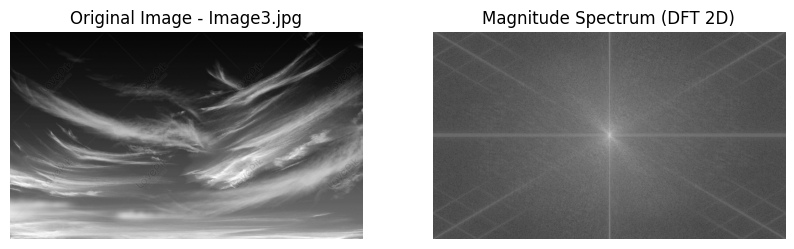

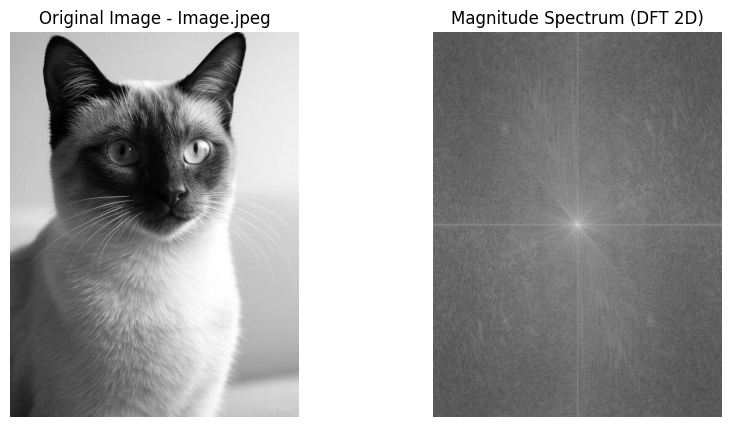

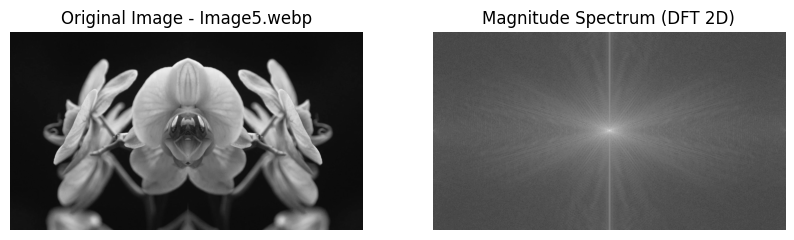

In [ ]:
# List of image paths
image_paths = ['assets/Image3.jpg', 'assets/Image.jpeg']

for path in image_paths:
    # Load grayscale image
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

    # Check if image is loaded correctly
    if img is None:
        print(f"Error: Cannot load image {path}")
        continue

    # Compute FFT and Shift
    dft = np.fft.fft2(img)
    dft_shift = np.fft.fftshift(dft)

    # Compute magnitude spectrum
    magnitude_spectrum = 20 * np.log(np.abs(dft_shift) + 1)

    # Display results
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.title(f'Original Image - {path.split("/")[-1]}')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(magnitude_spectrum, cmap='gray')
    plt.title('Magnitude Spectrum (DFT 2D)')
    plt.axis('off')

    plt.show()


## 🔍 Frequency Domain Filtering Overview

Once we have the Fourier-transformed image, we can apply filters in the frequency domain.

Filtering involves:
1. Transforming the image to the frequency domain using DFT.
2. Multiplying the frequency image by a **filter mask** (e.g., Low-pass, High-pass, or Band-pass).
3. Applying the inverse DFT to transform the filtered image back to the spatial domain.

Types of filters:
- **Low-Pass Filter (LPF)**: Keeps low frequencies → smooths/blurs.
- **High-Pass Filter (HPF)**: Keeps high frequencies → sharpens edges.
- **Band-Pass Filter (BPF)**: Keeps a specific range of frequencies → emphasizes textures.

## 🌫️ Low-Pass Filtering (Smoothing)

Low-Pass Filters (LPFs) preserve slow intensity variations (low frequencies) and suppress rapid changes (high frequencies).

Effect:
- Reduces noise.
- Produces a smoother or blurred image.


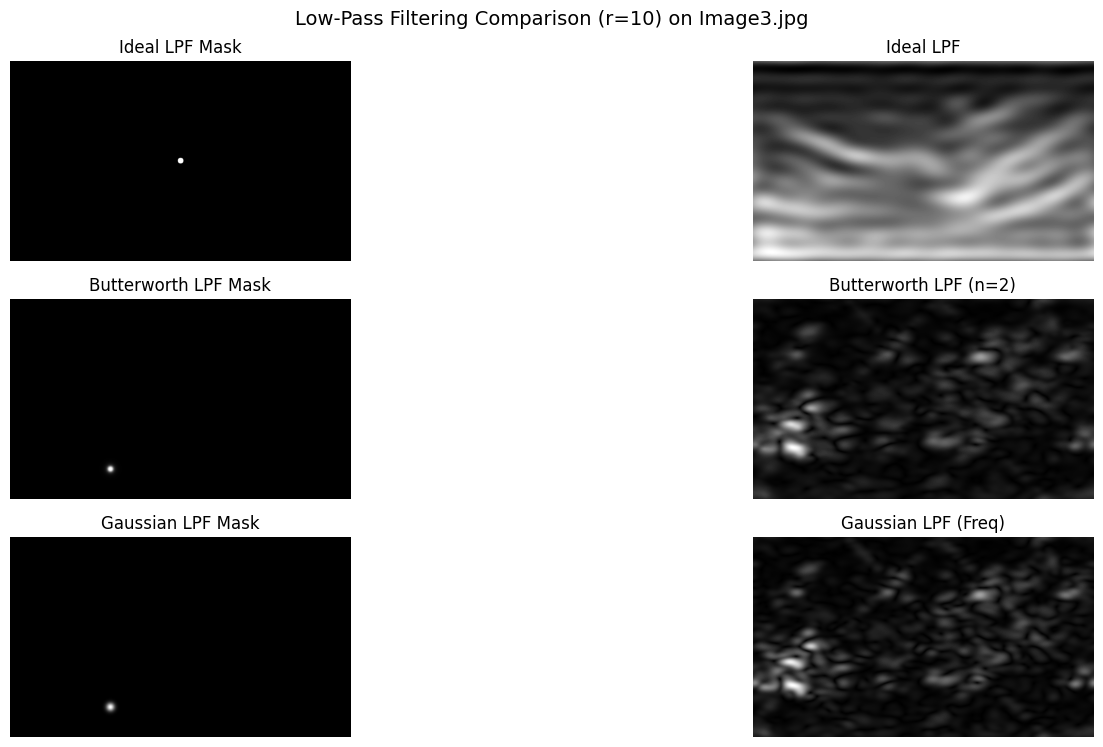

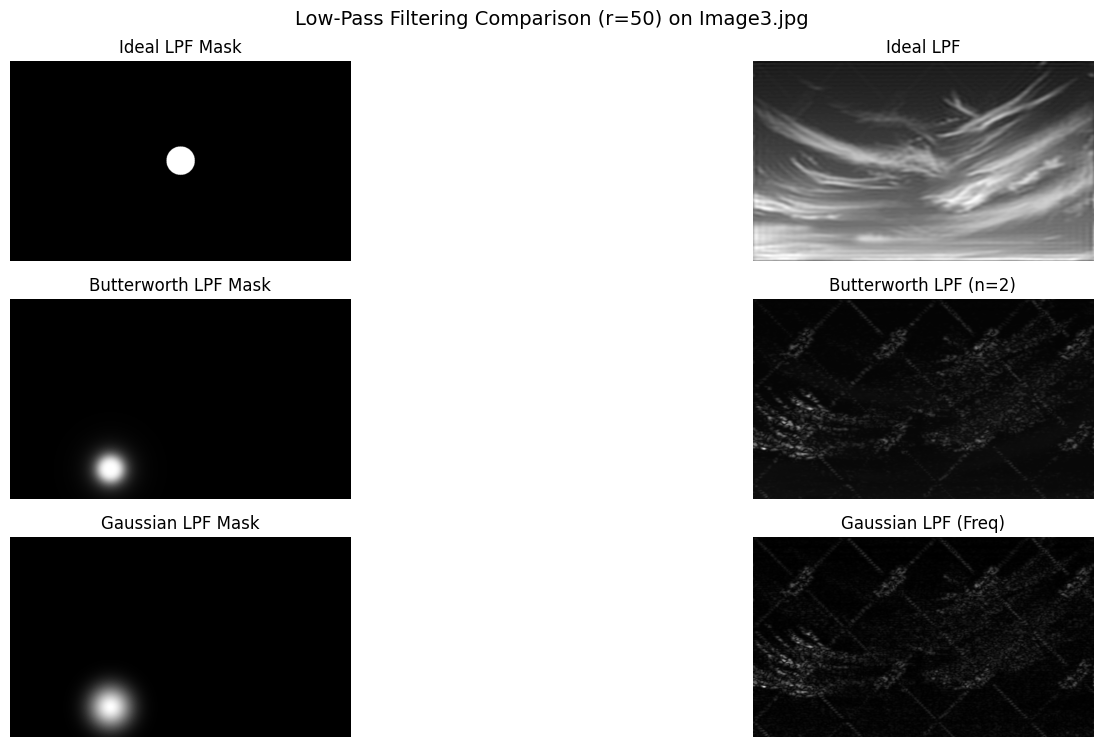

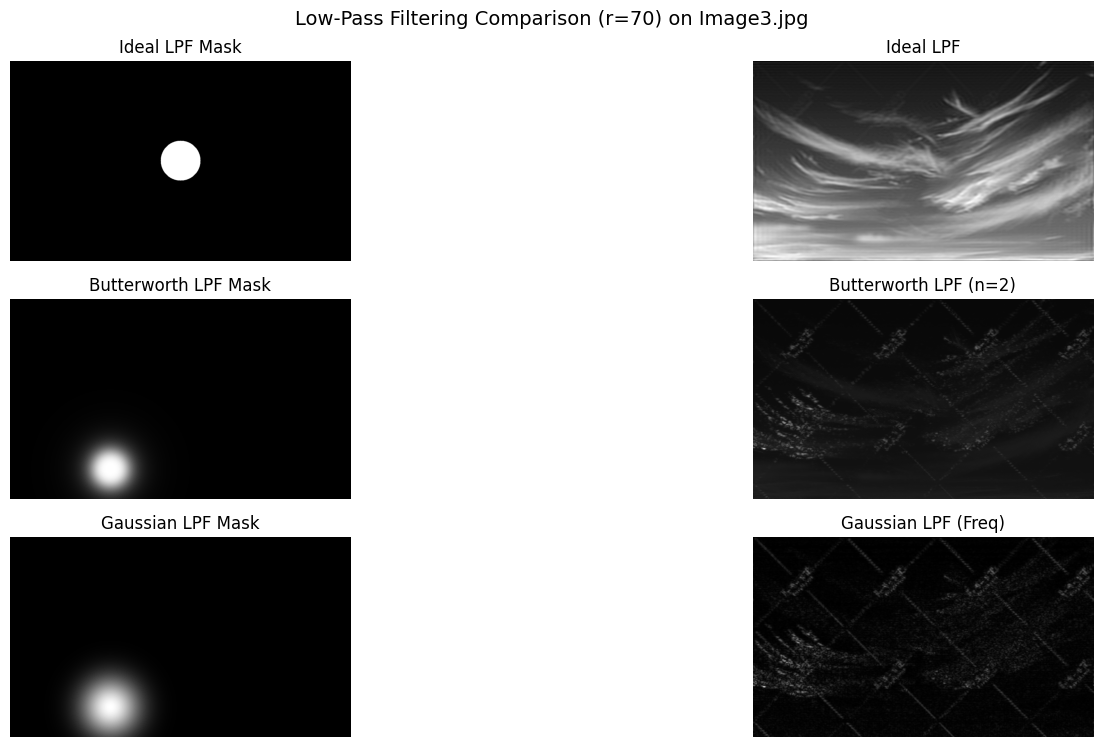

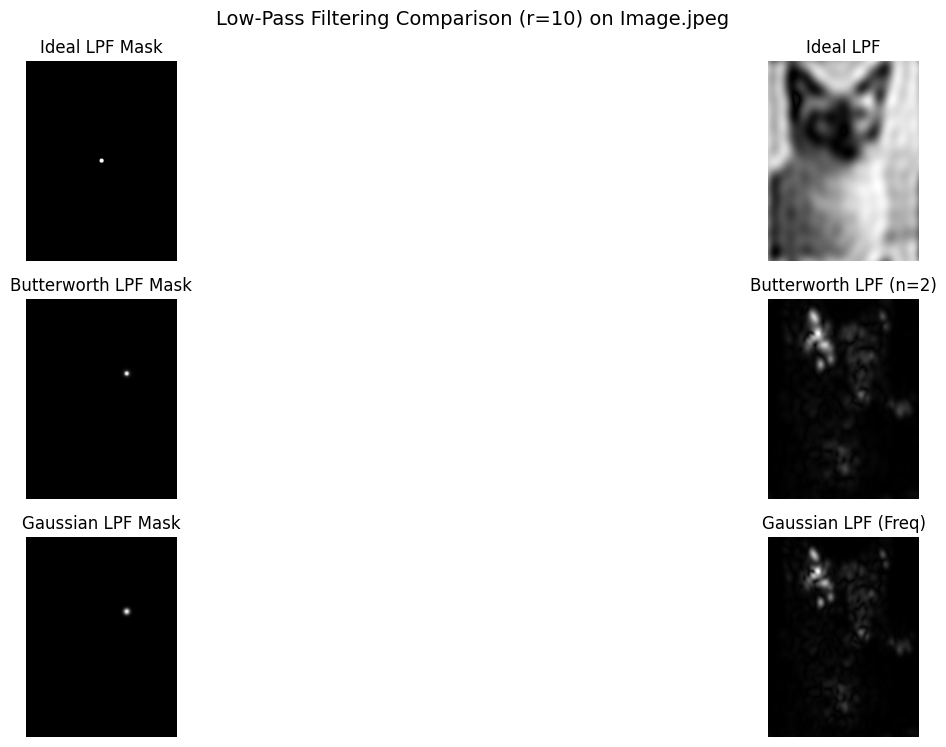

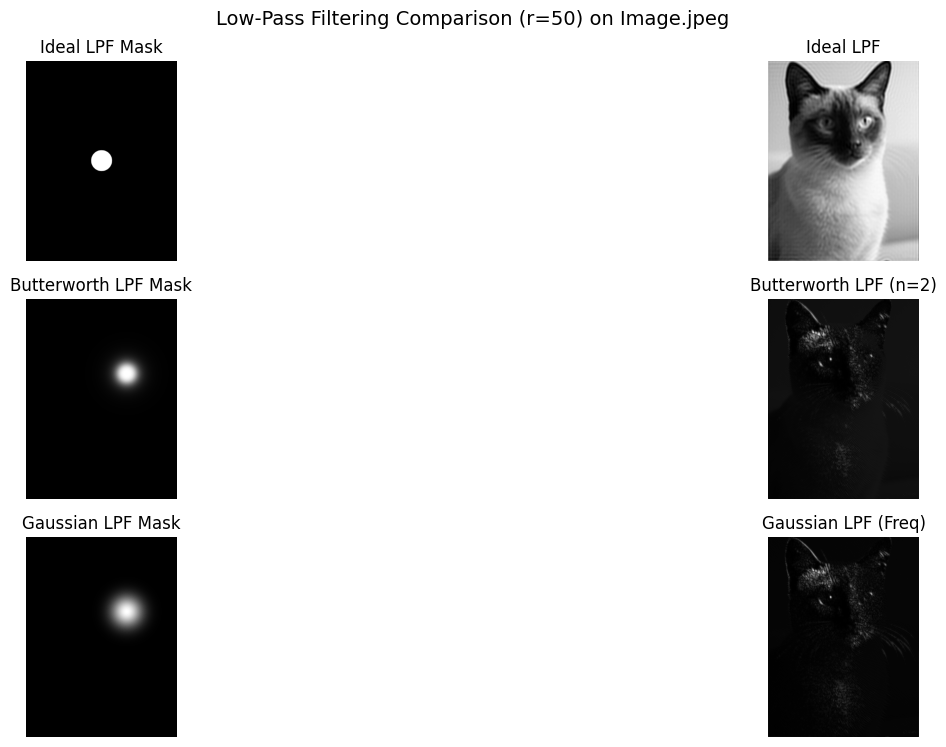

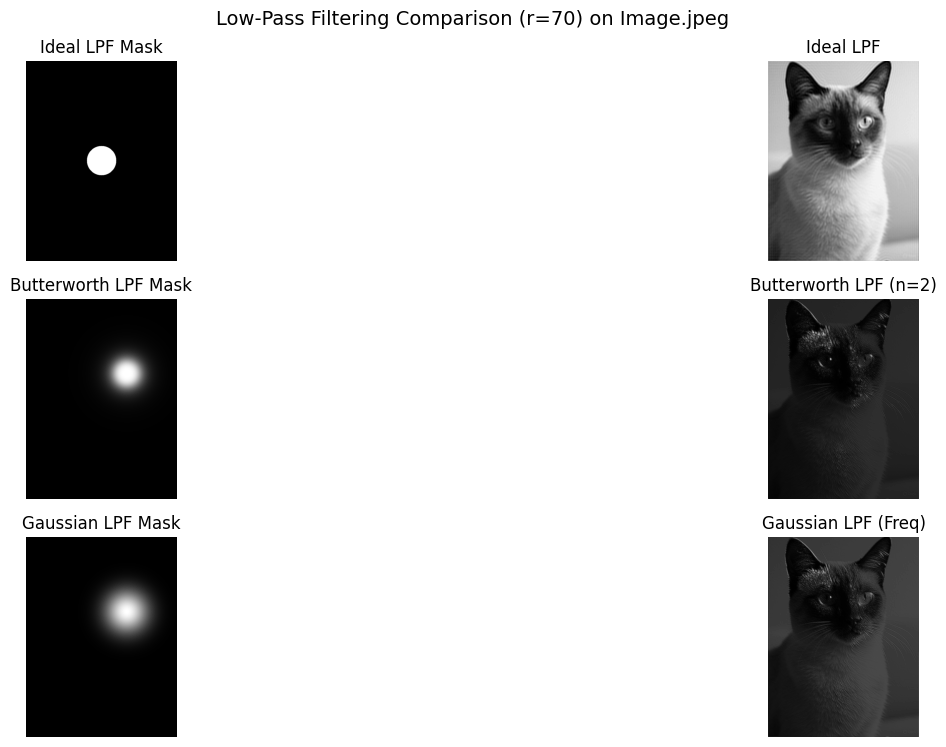

In [52]:
# List of image paths
image_paths = ['assets/Image3.jpg', 'assets/Image.jpeg']

for path in image_paths:
    # Load grayscale image
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Error: Cannot load image {path}")
        continue

    # Compute FFT and Shift
    dft = np.fft.fft2(img)
    dft_shift = np.fft.fftshift(dft)

    # Define cutoff radii
    radii = [10, 50, 70]
    n = 2  # Butterworth order

    # Get image size
    rows, cols = img.shape
    crow, ccol = rows // 2, cols // 2

    # Create meshgrid for distance computation
    u = np.arange(rows)
    v = np.arange(cols)
    V, U = np.meshgrid(v, u)
    D = np.sqrt((U - ccol) ** 2 + (V - crow) ** 2)

    # Process each radius
    for r in radii:
        # -------------------------
        # 1. Ideal LPF
        # -------------------------
        ideal_mask = np.zeros((rows, cols), np.uint8)
        cv2.circle(ideal_mask, (ccol, crow), r, 1, thickness=-1)

        # Apply Ideal LPF
        fshift_ideal = dft_shift * ideal_mask
        img_ideal = np.fft.ifft2(np.fft.ifftshift(fshift_ideal))
        img_ideal = np.abs(img_ideal)

        # -------------------------
        # 2. Butterworth LPF
        # -------------------------
        butter_mask = 1 / (1 + (D / r) ** (2 * n))
        fshift_butter = dft_shift * butter_mask
        img_butter = np.fft.ifft2(np.fft.ifftshift(fshift_butter))
        img_butter = np.abs(img_butter)

        # -------------------------
        # 3. Gaussian LPF
        # -------------------------
        gauss_mask = np.exp(-(D ** 2) / (2 * (r ** 2)))
        fshift_gauss = dft_shift * gauss_mask
        img_gauss_freq = np.fft.ifft2(np.fft.ifftshift(fshift_gauss))
        img_gauss_freq = np.abs(img_gauss_freq)

        # -------------------------
        # 4. Spatial Gaussian Blur
        # -------------------------
        ksize = int(r / 5) * 2 + 1  # ensure odd kernel size
        img_gauss_spatial = cv2.GaussianBlur(img, (ksize, ksize), 0)

        # --- Display results (4x2 grid) ---
        plt.figure(figsize=(15, 10))
        plt.suptitle(f"Low-Pass Filtering Comparison (r={r}) on {path.split('/')[-1]}", fontsize=14)

        # Masks (top row)
        plt.subplot(4, 2, 1)
        plt.imshow(ideal_mask, cmap='gray')
        plt.title('Ideal LPF Mask')
        plt.axis('off')

        plt.subplot(4, 2, 3)
        plt.imshow(butter_mask, cmap='gray')
        plt.title('Butterworth LPF Mask')
        plt.axis('off')

        plt.subplot(4, 2, 5)
        plt.imshow(gauss_mask, cmap='gray')
        plt.title('Gaussian LPF Mask')
        plt.axis('off')

        # Filtered images (bottom row)
        plt.subplot(4, 2, 2)
        plt.imshow(img_ideal, cmap='gray')
        plt.title('Ideal LPF')
        plt.axis('off')

        plt.subplot(4, 2, 4)
        plt.imshow(img_butter, cmap='gray')
        plt.title(f'Butterworth LPF (n={n})')
        plt.axis('off')

        plt.subplot(4, 2, 6)
        plt.imshow(img_gauss_freq, cmap='gray')
        plt.title('Gaussian LPF (Freq)')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

## ✴️ High-Pass Filtering (Sharpening)

High-Pass Filters (HPFs) preserve high-frequency components (edges and fine details) while removing low-frequency background information.

Effect:
- Enhances edges and sharp transitions.
- Makes the image appear sharper.


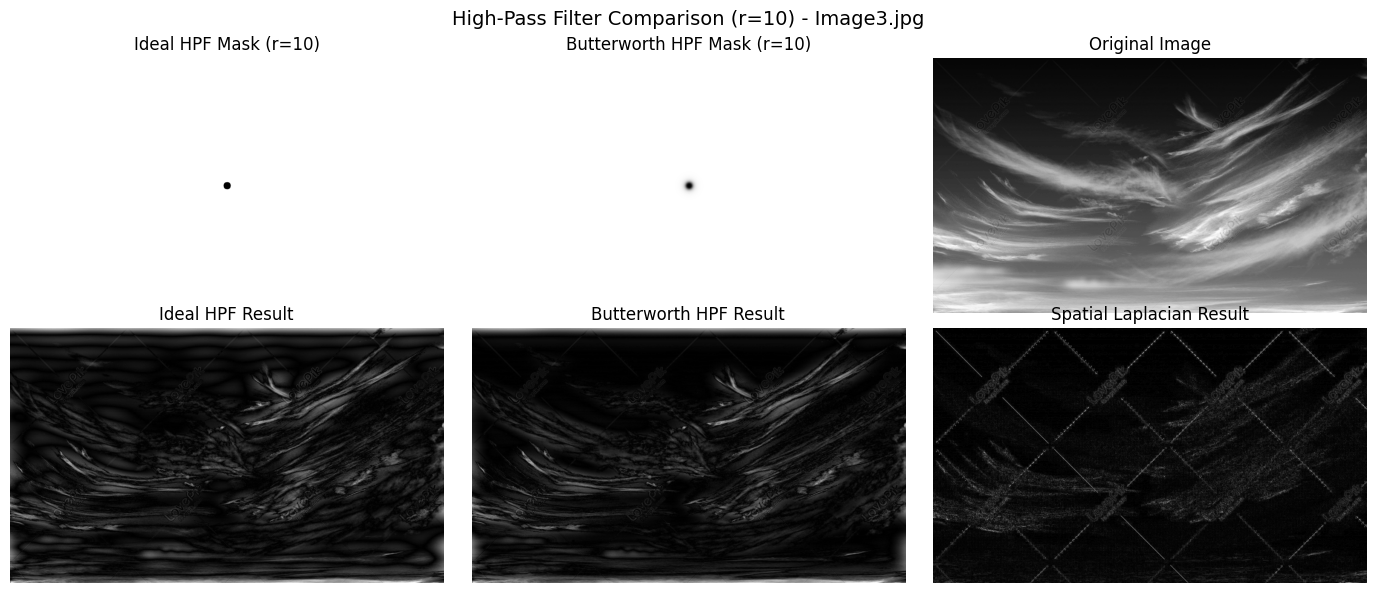

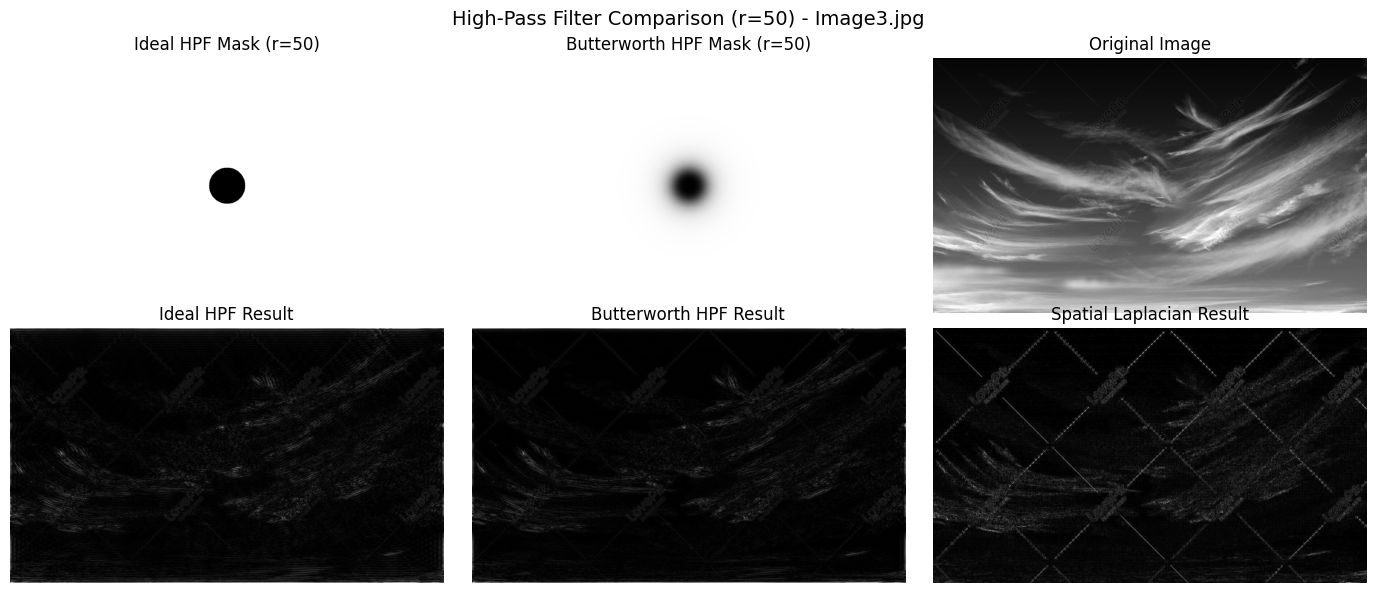

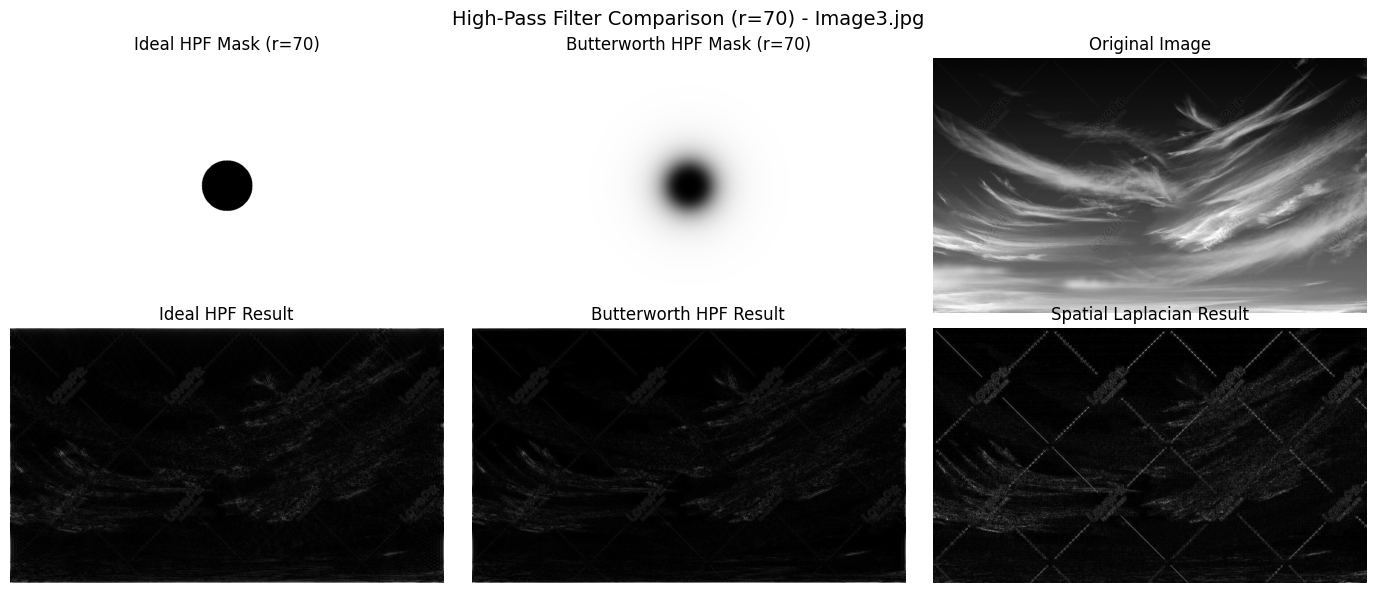

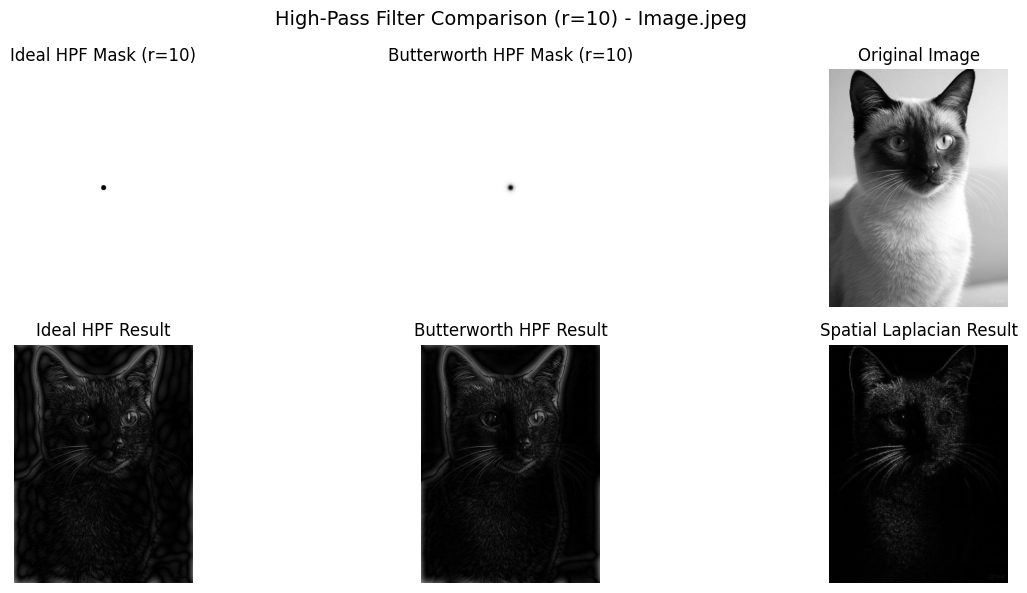

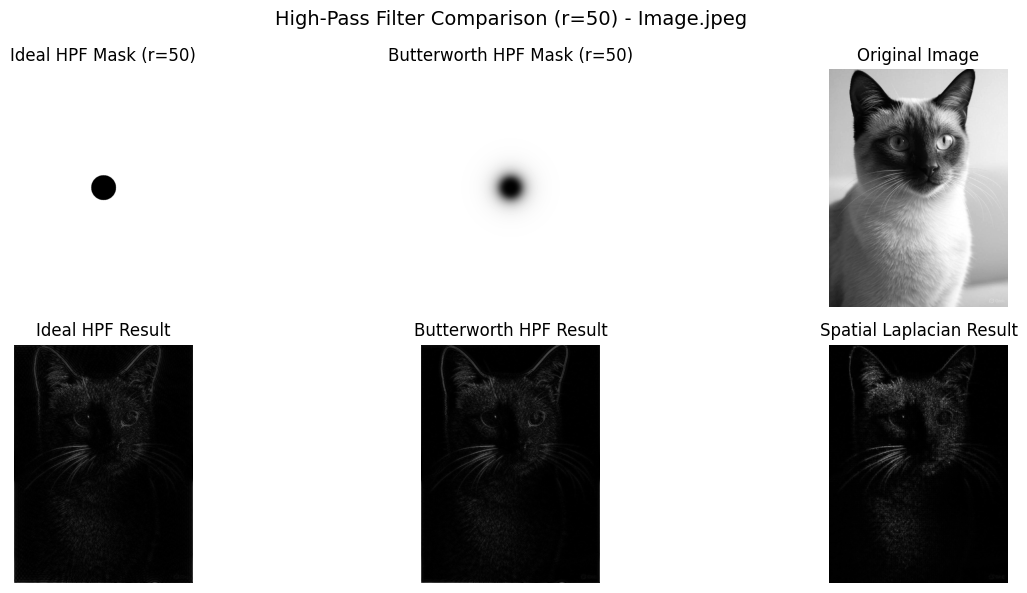

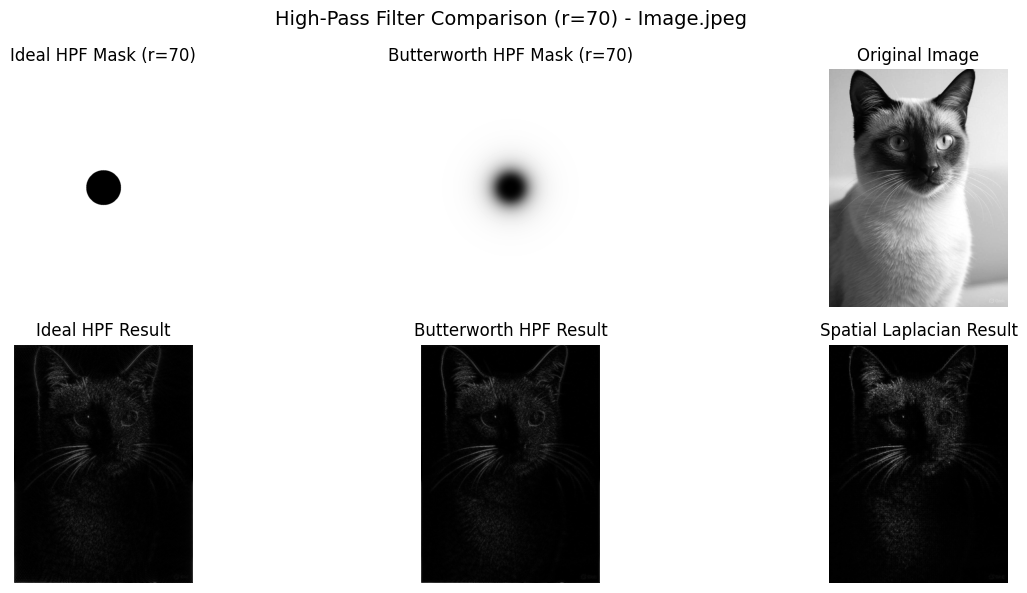

In [53]:
# --- Function to create Butterworth HPF mask ---
def butterworth_highpass(shape, cutoff, order=2):
    rows, cols = shape
    crow, ccol = rows // 2, cols // 2
    u = np.arange(rows)
    v = np.arange(cols)
    U, V = np.meshgrid(u - crow, v - ccol, indexing='ij')
    D = np.sqrt(U**2 + V**2)
    H = 1 / (1 + (cutoff / (D + 1e-5))**(2 * order))  # avoid divide by zero
    return H

# --- List of image paths ---
image_paths = ['assets/Image3.jpg', 'assets/Image.jpeg']

for path in image_paths:
    # Load grayscale image
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Error: Cannot load image {path}")
        continue

    # Compute FFT and Shift
    dft = np.fft.fft2(img)
    dft_shift = np.fft.fftshift(dft)

    # --- Define cutoff radii ---
    radii = [10, 50, 70]

    for r in radii:
        rows, cols = img.shape
        crow, ccol = rows // 2, cols // 2

        # --- 1️⃣ Ideal HPF mask ---
        ideal_mask = np.ones((rows, cols), np.uint8)
        cv2.circle(ideal_mask, (ccol, crow), r, 0, thickness=-1)

        # Apply Ideal HPF
        ideal_filtered = dft_shift * ideal_mask
        ideal_img = np.fft.ifft2(np.fft.ifftshift(ideal_filtered))
        ideal_img = np.abs(ideal_img)

        # --- 2️⃣ Butterworth HPF mask ---
        butter_mask = butterworth_highpass((rows, cols), cutoff=r, order=2)
        butter_filtered = dft_shift * butter_mask
        butter_img = np.fft.ifft2(np.fft.ifftshift(butter_filtered))
        butter_img = np.abs(butter_img)

        # --- 3️⃣ Spatial Laplacian Filter ---
        laplacian = cv2.Laplacian(img, cv2.CV_64F)
        laplacian_img = cv2.convertScaleAbs(laplacian)

        # --- 📊 Display comparison side-by-side ---
        plt.figure(figsize=(14, 6))
        plt.suptitle(f"High-Pass Filter Comparison (r={r}) - {path.split('/')[-1]}", fontsize=14)

        # Masks row
        plt.subplot(2, 3, 1)
        plt.imshow(ideal_mask, cmap='gray')
        plt.title(f'Ideal HPF Mask (r={r})')
        plt.axis('off')

        plt.subplot(2, 3, 2)
        plt.imshow(butter_mask, cmap='gray')
        plt.title(f'Butterworth HPF Mask (r={r})')
        plt.axis('off')

        plt.subplot(2, 3, 3)
        plt.imshow(img, cmap='gray')
        plt.title('Original Image')
        plt.axis('off')

        # Filtered results row
        plt.subplot(2, 3, 4)
        plt.imshow(ideal_img, cmap='gray')
        plt.title('Ideal HPF Result')
        plt.axis('off')

        plt.subplot(2, 3, 5)
        plt.imshow(butter_img, cmap='gray')
        plt.title('Butterworth HPF Result')
        plt.axis('off')

        plt.subplot(2, 3, 6)
        plt.imshow(laplacian_img, cmap='gray')
        plt.title('Spatial Laplacian Result')
        plt.axis('off')

        plt.tight_layout()
        plt.show()


## 🎚️ Band-Pass Filtering (Texture Analysis)

Band-Pass Filters (BPFs) retain a specific range of frequencies while blocking very low and very high frequencies.

Effect:
- Highlights textures or repeating patterns.
- Useful for texture classification and surface analysis.


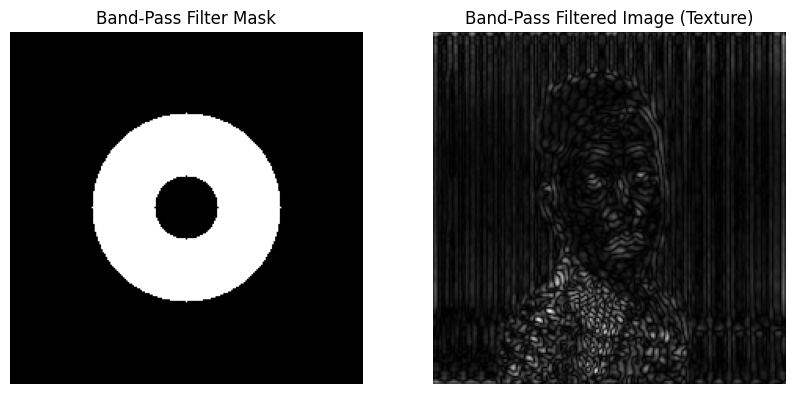

In [26]:
# Create Band-Pass Filter (difference of two LPFs)
mask = np.zeros((rows, cols), np.uint8)
r_in, r_out = 20, 60
cv2.circle(mask, (ccol, crow), r_out, 1, thickness=-1)
cv2.circle(mask, (ccol, crow), r_in, 0, thickness=-1)

# Apply BPF
fshift_BPF = dft_shift * mask
img_BPF = np.fft.ifft2(np.fft.ifftshift(fshift_BPF))
img_BPF = np.abs(img_BPF)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(mask, cmap='gray')
plt.title('Band-Pass Filter Mask')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img_BPF, cmap='gray')
plt.title('Band-Pass Filtered Image (Texture)')
plt.axis('off')
plt.show()


## 📊 Histogram and Contrast Enhancement

The histogram shows the distribution of intensity values in an image.

**Contrast Enhancement** improves visual clarity and highlights details.

Common methods:
- **Histogram Equalization**
- **Contrast Stretching**

Although these are spatial domain techniques, they complement frequency domain enhancement.


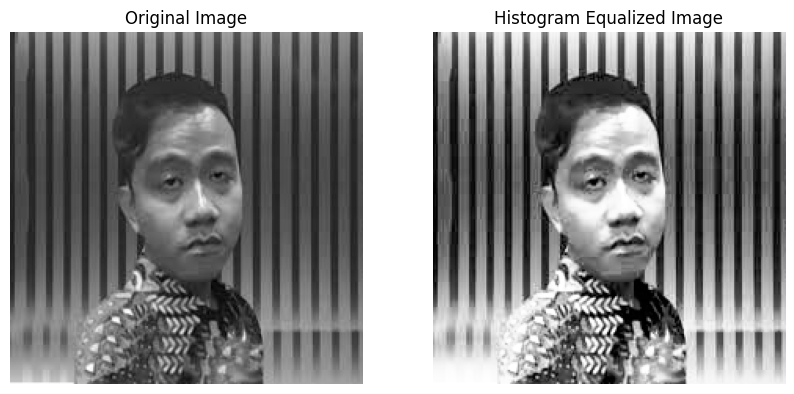

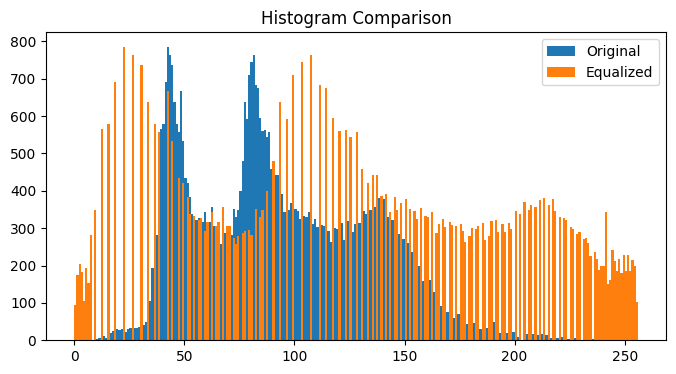

In [27]:
# Histogram Equalization
equalized = cv2.equalizeHist(img)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(equalized, cmap='gray')
plt.title('Histogram Equalized Image')
plt.axis('off')
plt.show()

# Plot histogram comparison
plt.figure(figsize=(8,4))
plt.hist(img.ravel(), 256, [0,256], label='Original')
plt.hist(equalized.ravel(), 256, [0,256], label='Equalized')
plt.legend()
plt.title('Histogram Comparison')
plt.show()

## ⚖️ Spatial vs Frequency Domain Filters

| Aspect | Spatial Domain | Frequency Domain |
|--------|----------------|------------------|
| Operation | Direct pixel manipulation | Transform-based modification |
| Examples | Smoothing, sharpening kernels | LPF, HPF, BPF |
| Computational Cost | Low for small filters | Efficient for large filters (via FFT) |
| Advantages | Simple, local control | Global frequency manipulation |
| Disadvantages | Limited to neighborhood effects | Harder to interpret visually |

Both domains are **complementary** — spatial filters manage local pixel variations, while frequency filters control global frequency components.


## 🔬 Practical Applications

- Noise removal in satellite or medical images.  
- Edge enhancement for object detection.  
- Texture segmentation in industrial inspection.  
- Preprocessing in machine vision systems.  
- Frequency-selective enhancement in astronomy and microscopy.


## 🧩 Summary

- The **2D Discrete Fourier Transform (DFT)** converts an image from spatial to frequency domain.  
- Filters like **Low-Pass**, **High-Pass**, and **Band-Pass** selectively modify frequency components.  
- The **Inverse DFT** reconstructs the enhanced image back in spatial form.  
- **Histogram Equalization** further improves visual contrast.  
- Combining spatial and frequency domain techniques yields powerful image enhancement results.